<a href="https://colab.research.google.com/github/Guttinasravani/FMML-LABS-AND-PROJECTS/blob/main/FMML_M2Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods



Today, we will be focussing on non-linear dimensionality reduction methods or **Manifold learning** methods.

So a manifold is any space that is locally Euclidean. For example, the Earth is round but it looks flat to us. The Earth is a manifold: locally it is flat, but globally we know it is a sphere. Then, manifold learning performs dimensionality reduction by representing data as low-dimensional manifolds embedded in a higher-dimensional space.

We often suspect that high-dim may actually lie on or near a low-dim manifold (often much lower!) and it would be useful if we could reparametrize the data in terms of this manifold, yielding a low-dim embedding BUT - we typically don’t know the form of this manifold.

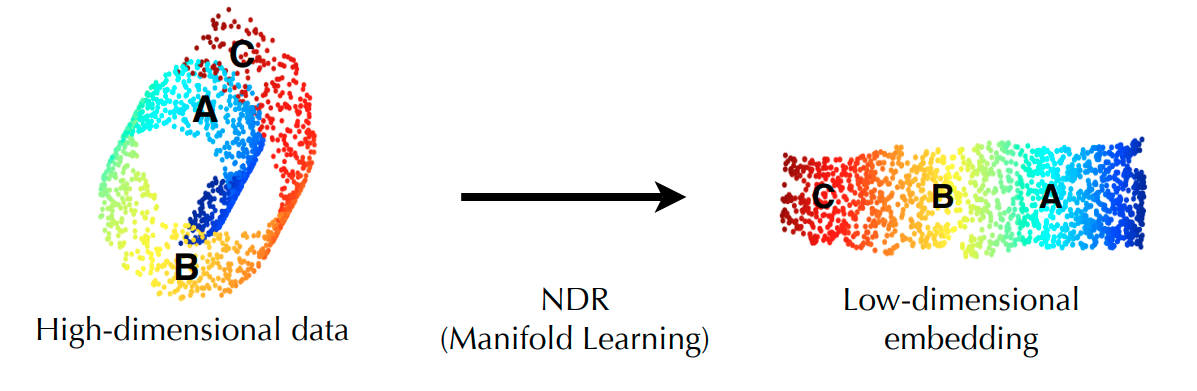

## ISOMAP

---

Isomap stands for **ISOmetric feature MAPping**. Isomap is a non-linear dimensionality reduction method based on the spectral theory which tries to preserve the geodesic distances in the lower dimension.

#### But what are Geodesic Distances?



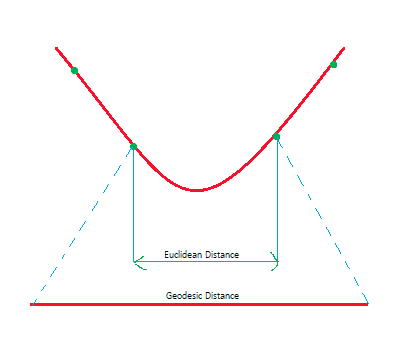

The next question should be:

*How can we compute geodesics without knowing the manifold?* .......
ANSWER: So we build an adjacency graph and approximate geodesic distances by shortest-paths through the graph.


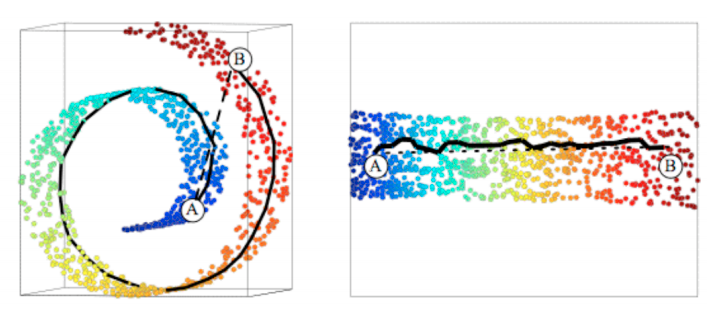

#### 3 steps for ISOMAP:

1. Build the adjacency graph over the points using a Neighbourhood selection method (let's say k nearest neighbours)
2. Compute approximate geodesics: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.
3. Take the top d eigenvectors of the Gram matrix.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

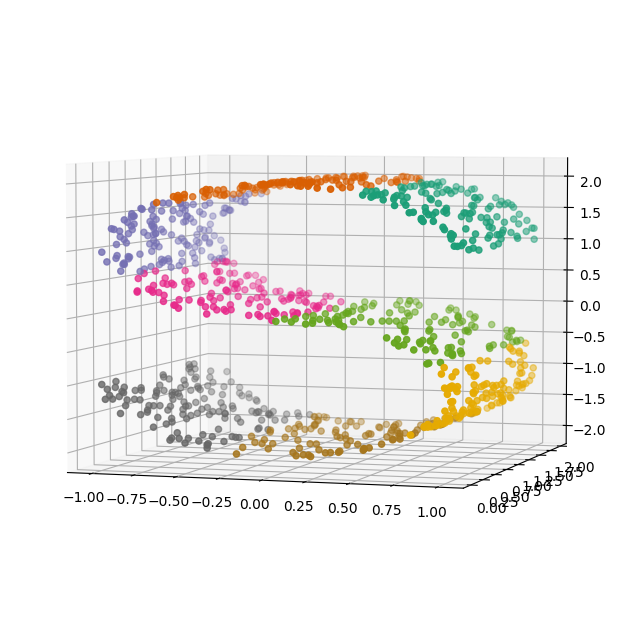

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

Note that all the points appear to be a lying on a curved 2d plane in this 3d dataset. Now we will be coding the Isomap algorithm to perform this manifold learning.


---

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [4]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1000 points, so we expect the dimensions of this matrix to be 1000x1000
print(distances.shape)

(1000, 1000)


### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [5]:
# Lets keep only the 10 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [ ]:
neighbors.shape

(1000, 1000)



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

We will be using the graph_shortest_path() function in the sklearn.utils.graph module.

The function takes an array of positive distances as the parameter. It then performs a shortest-path graph search on the graph and returns a matrix G (shape = N,N), where, G(i,j) gives the shortest distance from point i to point j along the graph.


In [6]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


So let us first compute the gram matrix. If we have a matrix **graph**, then its Gram matrix is **graph**.T * **graph**





In [15]:
gram = (graph ** 2)

We will now be computing the eigenvectors for this matrix, so lets first center the data points.

In [16]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1000,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

Computing eigenvectors

In [17]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T



---

## Plotting the resultant reduced_matrix


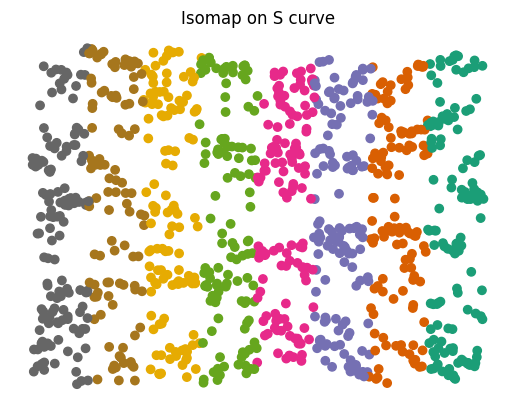

In [18]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

##### As you can see the Isomap was able to capture the underlying 2d manifold in the S curve dataset.

Now of course there is an easier way to do this, using a predefined library Isomap by sklearn in the manifold module. It just requires you to enter the number of neighbours to be considered and the number of components the graph is to be reduced to.


In [19]:
from sklearn.manifold import Isomap

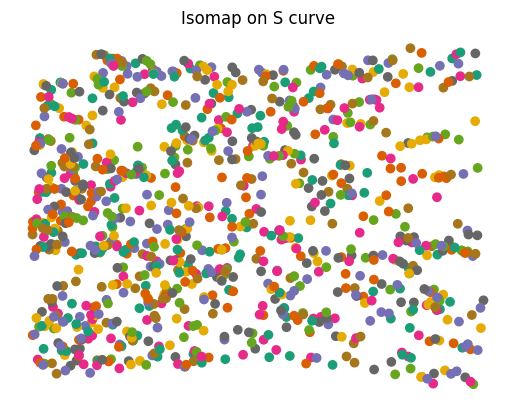

In [20]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

We loaded 766 images, each having 2914 pixels. Let us visualize our dataset before reducing the dimension

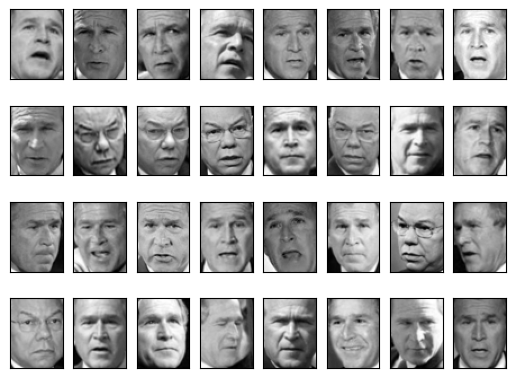

In [22]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Our data is 2914 dimensional and our goal is to learn a low dimensional manifold from it. We first apply PCA (which we learn in Lab 2) and see if PCA is able to reduce it to lower dimensions while preserving much of the variance.

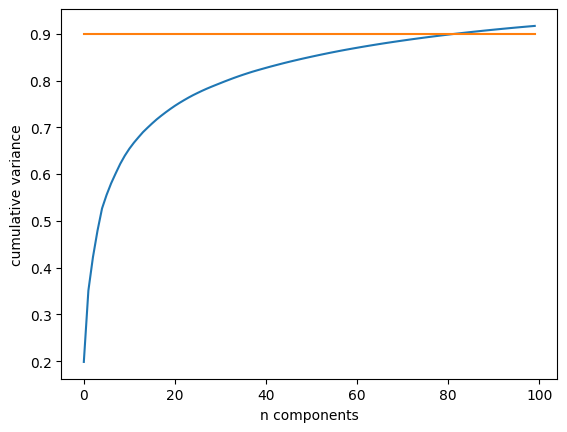

In [23]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

So we can clearly observe that PCA requires more than 70 dimensions to be able to explain 90% of the variance, implying that PCA is failing to learn the underlying manifold effectively.

Let us now try to apply Isomap to this dataset and see if it is able to learn the representation effectively.

In [24]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

We have reduced the dataset from 2914 dimensions to just 2 dimensions. Let us now visualize the result to be able to better understand the latent representation learnt by Isomap

In [25]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

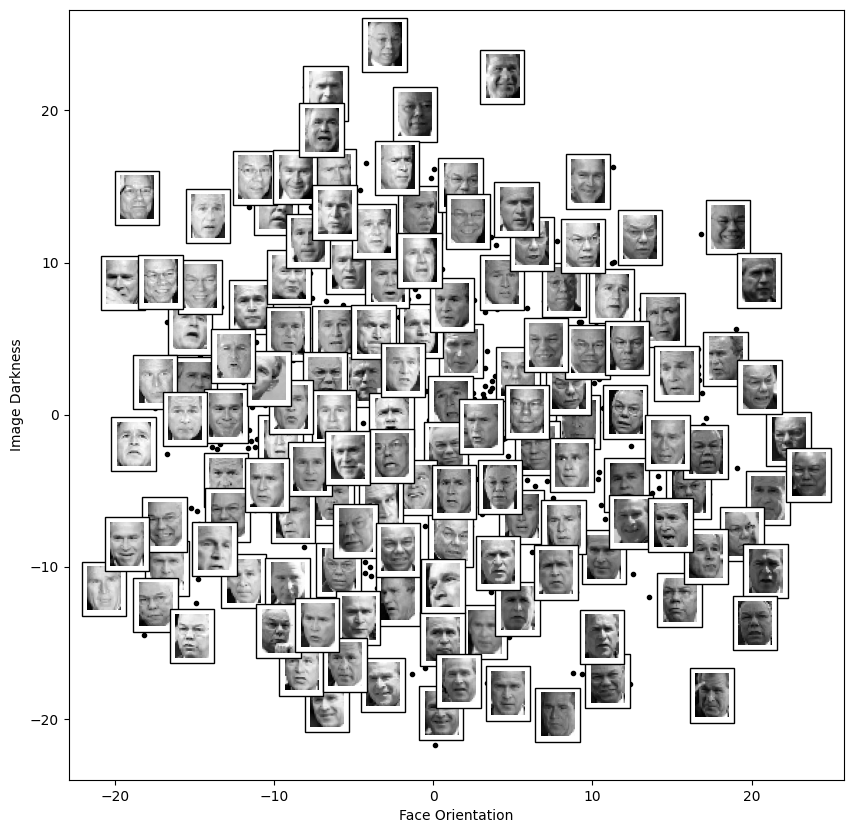

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

We get a very interesting result here. You can see that the Isomap was able to capture very interesting insights regarding the dataset.

If you observe along the x-axis, the images are positioned such that the orientation of the faces changes from left to right. Similarly, the darkness of the image increases in the positive direction of the y-axis.

This clearly indicates that Isomap was able to capture the underlying manifold very precisely in just 2 dimensions.

You are motivated to play around with the number of neighbors and check if the following holds true across neighbourhoods!

**#Impact of Neighborhood Size on Isomap Algorithm: Effects of Large and Small Neighborhoods**


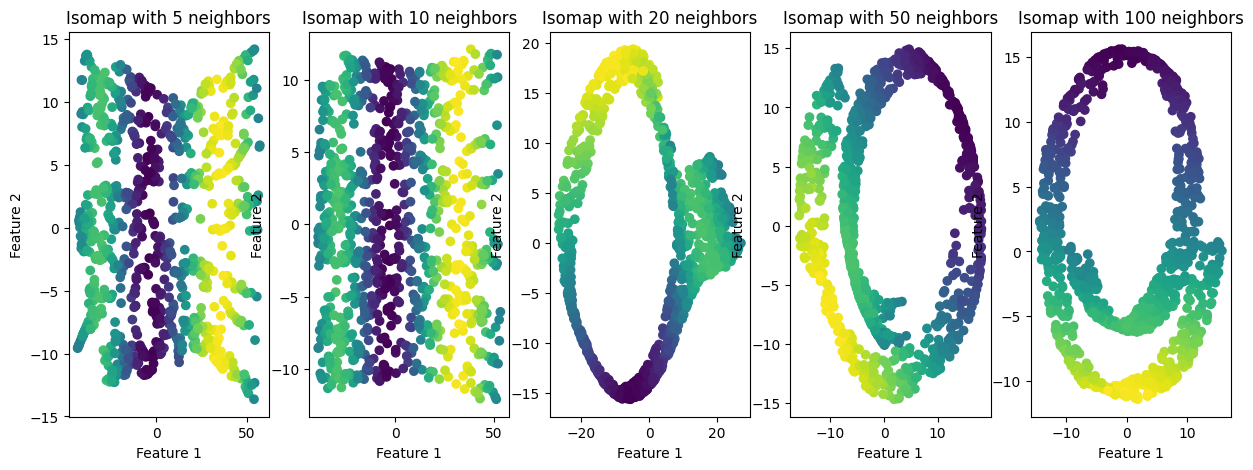

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.datasets import make_swiss_roll

# Generate a sample dataset (Swiss roll)
n_samples = 1000
X, _ = make_swiss_roll(n_samples, noise=0.1)

# Define the number of neighbors to consider
n_neighbors_list = [5, 10, 20, 50, 100]

# Create a figure to plot the results
fig, axs = plt.subplots(1, len(n_neighbors_list), figsize=(15, 5))

for i, n_neighbors in enumerate(n_neighbors_list):
    # Create an Isomap object with the specified number of neighbors
    iso = Isomap(n_neighbors=n_neighbors)

    # Fit the Isomap algorithm to the data
    X_iso = iso.fit_transform(X)

    # Plot the results
    axs[i].scatter(X_iso[:, 0], X_iso[:, 1], c=X[:, 0])
    axs[i].set_title(f"Isomap with {n_neighbors} neighbors")
    axs[i].set_xlabel("Feature 1")
    axs[i].set_ylabel("Feature 2")

plt.show()

This code creates a sample dataset with Swiss roll dataset and applies Isomap algorithm with varying number of neighbor (5, 10, 20, 50, 100) The plots that follow show the performance impact of the number of neighbors in the dimensionality reduction.

However, please remember that the practical choice of the number of neighbors that should be used will depend on some properties of the given data as well as on the target result. This code is just for demonstration of the impact of the parameter neighbors on the Isomap algorithm.



**#Scenarios Where Isomap Outperforms PCA**


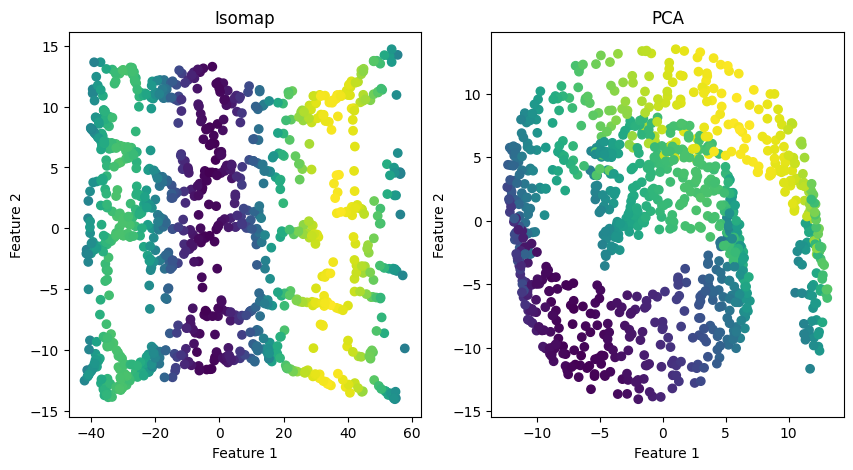

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.datasets import make_swiss_roll

# Generate a sample dataset (Swiss roll)
n_samples = 1000
X, _ = make_swiss_roll(n_samples, noise=0.1)

# Define the number of components to retain
n_components = 2

# Create an Isomap object
iso = Isomap(n_components=n_components)
X_iso = iso.fit_transform(X)

# Create a PCA object
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Create a figure to plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the Isomap results
axs[0].scatter(X_iso[:, 0], X_iso[:, 1], c=X[:, 0])
axs[0].set_title("Isomap")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")

# Plot the PCA results
axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=X[:, 0])
axs[1].set_title("PCA")
axs[1].set_xlabel("Feature 1")
axs[1].set_ylabel("Feature 2")

plt.show()

This code generates a sample dataset using the Swiss roll dataset, and then applies both Isomap and PCA to reduce the dimensionality of the data to 2 components. The resulting plots show the performance of both algorithms in capturing the underlying structure of the data.

**#Isomap vs LLE (Locally Linear Embedding): Isomap focuses on global geometry, whereas LLE focuses on local geometry. Isomap tries to preserve the geodes**

Other Manifold Learning Methods and Their Key Differences

Besides Isomap, there are several other manifold learning methods, each with its strengths and weaknesses. Here are some of the popular ones:

Locally Linear Embedding (LLE) : LLE is a method that tries to preserve the local geometry of the data. It does this by representing each data point as a linear combination of its neighbors. The key difference between LLE and Isomap is that LLE focuses on local geometry, whereas Isomap focuses on global geometry.

Laplacian Eigenmaps: Laplacian Eigenmaps is a method that uses the Laplace-Beltrami operator to find the low-dimensional representation of the data. The key difference between Laplacian Eigenmaps and Isomap is that Laplacian Eigenmaps uses the Laplace-Beltrami operator, whereas Isomap uses the geodesic distance.

t-Distributed Stochastic Neighbor Embedding (t-SNE): t-SNE is a method that tries to preserve the local geometry of the data by minimizing the Kullback-Leibler divergence between the high-dimensional data and the low-dimensional representation. The key difference between t-SNE and Isomap is that t-SNE focuses on local geometry, whereas Isomap focuses on global geometry.

Uniform Manifold Approximation and Projection (UMAP): UMAP is a method that tries to preserve the global geometry of the data by minimizing the cross-entropy between the high-dimensional data and the low-dimensional representation. The key difference between UMAP and Isomap is that UMAP focuses on global geometry, whereas Isomap focuses on global geometry as well, but uses a different approach.

Diffusion Maps: Diffusion Maps is a method that uses the diffusion process to find the low-dimensional representation of the data. The key difference between Diffusion Maps and Isomap is that Diffusion Maps uses the diffusion process, whereas Isomap uses the geodesic distance.

Hessian Locally Linear Embedding (Hessian LLE): Hessian LLE is a method that tries to preserve the local geometry of the data by using the Hessian matrix. The key difference between Hessian LLE and Isomap is that Hessian LLE focuses on local geometry, whereas Isomap focuses on global geometry.

Local Tangent Space Alignment (LTSA): LTSA is a method that tries to preserve the local geometry of the data by aligning the local tangent spaces. The key difference between LTSA and Isomap is that LTSA focuses on local geometry, whereas Isomap focuses on global geometry.

Maximum Variance Unfolding (MVU): MVU is a method that tries to preserve the global geometry of the data by maximizing the variance of the low-dimensional representation. The key difference between MVU and Isomap is that MVU focuses on global geometry, whereas Isomap focuses on global geometry as well, but uses a different approach.

Sammon's Mapping: Sammon's Mapping is a method that tries to preserve the global geometry of the data by minimizing the stress between the high-dimensional data and the low-dimensional representation. The key difference between Sammon's Mapping and Isomap is that Sammon's Mapping focuses on global geometry, whereas Isomap focuses on global geometry as well, but uses a different approach.

Autoencoders: Autoencoders are a type of neural network that can be used for manifold learning. The key difference between autoencoders and Isomap is that autoencoders are a type of neural network, whereas Isomap is a type of manifold learning algorithm.



In [10]:
import pandas as pd
from google.colab import drive
from sklearn.manifold import LocallyLinearEmbedding , TSNE, SpectralEmbedding, MDS
import gdown

# Download the CSV file from the shared link
url = 'https://drive.google.com/file/d/1dqqLxNTyF_zpIzU9j8V_jBulw8t1gYX1/view?usp=drive_link'
file_id = url.split('/')[-2]
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'heart.csv', fuzzy=True)

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('heart.csv')

# Convert the DataFrame to a NumPy array
X = df.values

# LLE
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
X_lle = lle.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Laplacian Eigenmaps
laplacian_eigenmaps = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
X_laplacian_eigenmaps = laplacian_eigenmaps.fit_transform(X)

# HLLE
hlle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, hessian_tol=0.1)
X_hlle = hlle.fit_transform(X)

# Diffusion Maps
diffusion_maps = SpectralEmbedding(n_components=2, affinity='rbf')
X_diffusion_maps = diffusion_maps.fit_transform(X)

# MDS
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X)

# Autoencoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

input_dim = X_pca.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(X_pca, X_pca, epochs=100, batch_size=32, shuffle=True)

encoder_layer = Model(inputs=input_layer, outputs=encoder)
X_autoencoder = encoder_layer.predict(X_pca)

Downloading...
From: https://drive.google.com/uc?id=1dqqLxNTyF_zpIzU9j8V_jBulw8t1gYX1
To: /content/heart.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 9.23MB/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6646
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6470 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6265 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6130  
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6170  
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5972 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5668 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5699 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5590  
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5351  
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5389 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5156  
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4983  
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4750  
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

**#Suggest ways to deal with missing data in manifold learning.**

Dealing with missing data is a crucial step in manifold learning, as most manifold learning algorithms are not designed to handle missing values. Here are some ways to deal with missing data in manifold learning:

Listwise Deletion: This involves removing any data points that have missing values. This method is simple but can be problematic if there are many missing values, as it can lead to a significant loss of information.

Pairwise Deletion: This involves removing only the missing values and not the entire data point. This method can be used when the missing values are scattered throughout the dataset.

Mean/Median/Mode Imputation: This involves replacing the missing values with the mean, median, or mode of the respective feature. This method is simple but can be problematic if the data is not normally distributed.

Regression Imputation: This involves using a regression model to predict the missing values based on the other features. This method can be more accurate than mean/median/mode imputation but can be computationally expensive.

K-Nearest Neighbors (KNN) Imputation: This involves finding the k-nearest neighbors to the data point with missing values and using their values to impute the missing values. This method can be more accurate than mean/median/mode imputation but can be computationally expensive.

Multiple Imputation: This involves creating multiple versions of the dataset, each with different imputed values, and then combining the results. This method can be more accurate than single imputation methods but can be computationally expensive.

Matrix Completion: This involves using matrix completion algorithms to impute the missing values. This method can be more accurate than other imputation methods but can be computationally expensive.

Robust Manifold Learning: This involves using manifold learning algorithms that are robust to missing values. These algorithms can handle missing values without the need for imputation.

In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.manifold import LocallyLinearEmbedding

# Create a sample dataset with missing values
data = pd.DataFrame({
    'A': [1, 2, np.nan, 4, 5],
    'B': [6, np.nan, 8, 9, 10],
    'C': [11, 12, 13, np.nan, 15]
})

# Use mean imputation to replace missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)

# Use manifold learning to reduce the dimensionality of the data
lle = LocallyLinearEmbedding(n_neighbors=4, n_components=2)
data_reduced = lle.fit_transform(data_imputed)

# Print the reduced data
print(data_reduced)

[[ 6.78540067e-01  3.36789552e-01]
 [ 1.98955718e-01 -5.46475983e-01]
 [ 5.78981307e-13  4.19372860e-01]
 [-1.98955718e-01 -5.46475983e-01]
 [-6.78540067e-01  3.36789552e-01]]


In this example, we use the SimpleImputer class from scikit-learn to replace missing values with the mean of the respective feature. We then use the LocallyLinearEmbedding class to reduce the dimensionality of the data.


---


### Some interesting references:

1) https://axon.cs.byu.edu/Dan/678/miscellaneous/Manifold.example.pdf

2) http://vision.cse.psu.edu/seminars/talks/PRML/David_NDR_lecture.pdf


---

